## --------------------------------------------------------------------------------------------------------------------------

# Parking Slot Prediction Project

# Library Imports for Data Analysis/Modeling

## --------------------------------------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
# color_pal = sns.color_palette()
# plt.style.use('fivethirtyeight')

In [4]:
# Load the data
df = pd.read_csv('Parking_Data_Fixed.csv')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

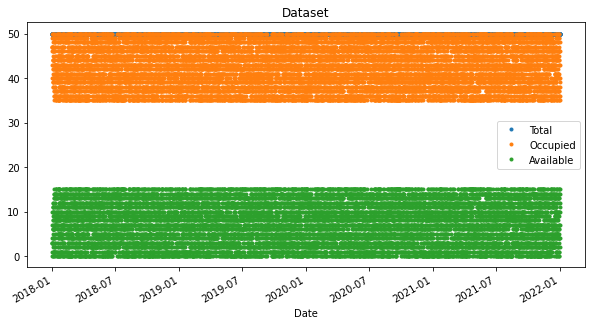

In [5]:
# Plot the availability
df.plot(style='.', figsize=(10, 5), title='Dataset')
plt.show()

## --------------------------------------------------------------------------------------------------------------------------

# Data Train/Test Split for Model Training and Evaluation

## --------------------------------------------------------------------------------------------------------------------------

In [6]:
# Split into train and test sets
train = df.loc[df.index < '01-06-2020']
test = df.loc[df.index >= '01-06-2020']

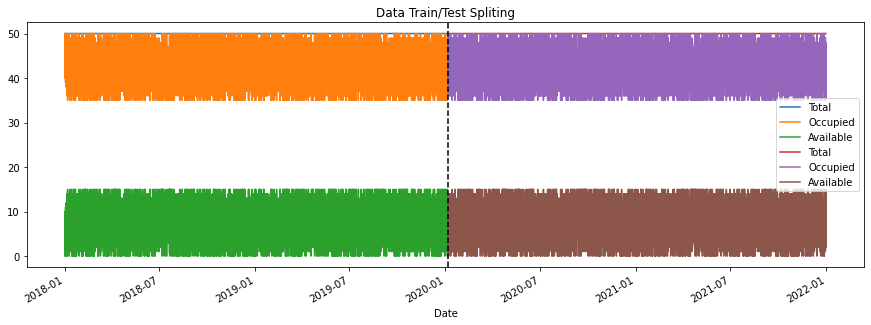

In [7]:
# Plot the train/test split
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax,  title='Data Train/Test Spliting')
test.plot(ax=ax )
ax.axvline('01-06-2020', color='black', ls='--')
# ax.legend(['Training Set', 'Test Set'])
plt.show()

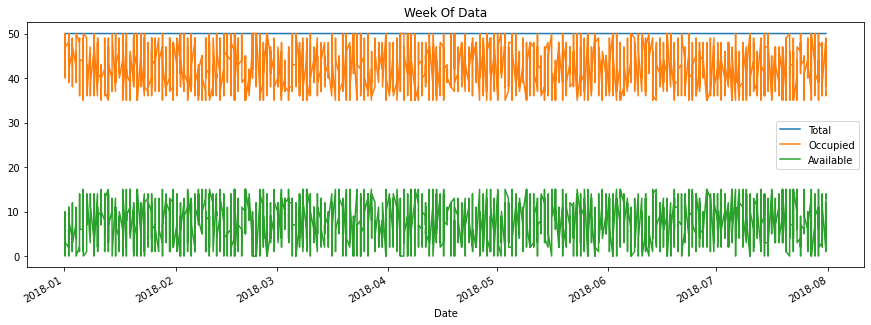

In [8]:
# Plot a week's worth of data
df.loc[(df.index > '01-01-2018') & (df.index < '08-01-2018')].plot(figsize=(15, 5), title='Week Of Data')
plt.show()

## --------------------------------------------------------------------------------------------------------------------------

# Improving Model Performance through Feature Creation

## --------------------------------------------------------------------------------------------------------------------------

In [9]:
# Define a function to create features
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [10]:
# Create features
df = create_features(df)

## --------------------------------------------------------------------------------------------------------------------------

# Exploring the Correlation Between Features and Target Variable

## --------------------------------------------------------------------------------------------------------------------------

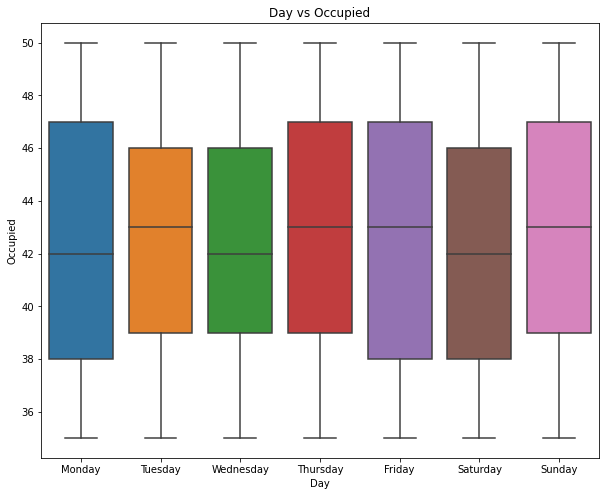

In [11]:

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Day', y='Occupied')
ax.set_title('Day vs Occupied')
plt.show()

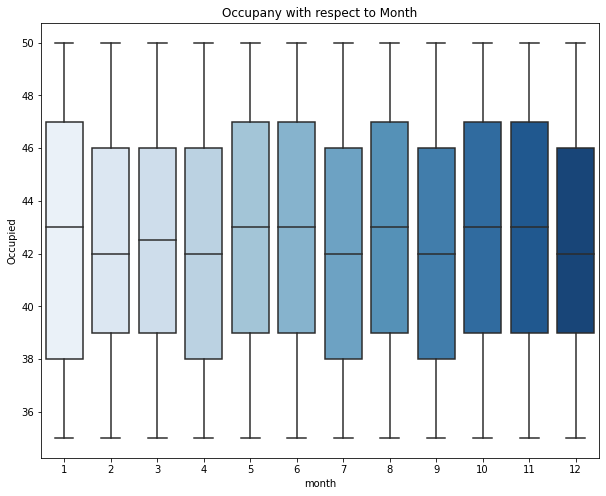

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Occupied', palette='Blues')
ax.set_title('Occupany with respect to Month')
plt.show()

## --------------------------------------------------------------------------------------------------------------------------

# Building and Training the Model

## --------------------------------------------------------------------------------------------------------------------------

In [13]:
# Define the features and target
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Occupied'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [14]:
# Define and train the model
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[20:18:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:41.88378	validation_1-rmse:41.87548
[100]	validation_0-rmse:15.91784	validation_1-rmse:15.90721
[200]	validation_0-rmse:7.22329	validation_1-rmse:7.31228
[300]	validation_0-rmse:5.00996	validation_1-rmse:5.06602
[400]	validation_0-rmse:4.62643	validation_1-rmse:4.66863
[500]	validation_0-rmse:4.56513	validation_1-rmse:4.60769
[600]	validation_0-rmse:4.54838	validation_1-rmse:4.59895
[700]	validation_0-rmse:4.53960	validation_1-rmse:4.59891
[712]	validation_0-rmse:4.53864	validation_1-rmse:4.59923


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

## --------------------------------------------------------------------------------------------------------------------------

# Analysis of Feature Importance for Model Performance

## --------------------------------------------------------------------------------------------------------------------------

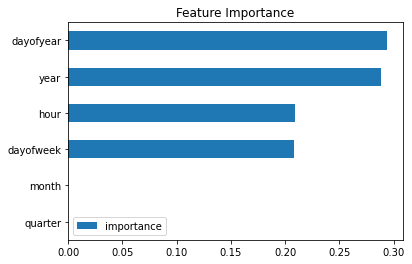

In [15]:
fi = pd.DataFrame(data=reg.feature_importances_,
index=reg.feature_names_in_,
columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## --------------------------------------------------------------------------------------------------------------------------

# Model Performance on Test Data: Forecast vs Actual

## --------------------------------------------------------------------------------------------------------------------------

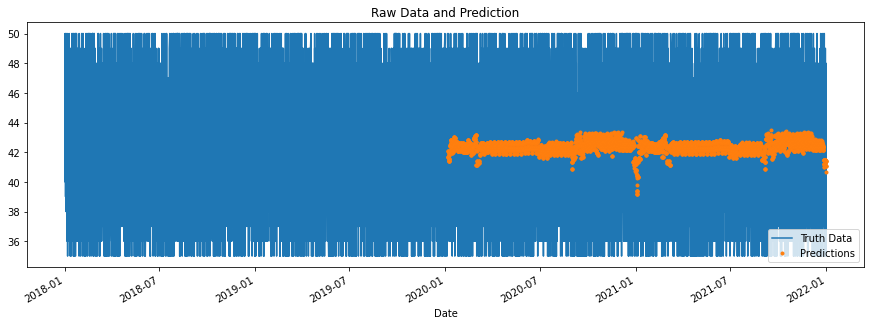

In [16]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Occupied']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [17]:
# ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['Occupied'].plot(figsize=(15, 5), title='Week Of Data')
# df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style='.')
# plt.legend(['Truth Data', 'Prediction'])
# plt.show()

## --------------------------------------------------------------------------------------------------------------------------

# Root Mean Square Error (RMSE) Score Analysis

## --------------------------------------------------------------------------------------------------------------------------

In [18]:
score = np.sqrt(mean_squared_error(test['Occupied'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 4.60


## --------------------------------------------------------------------------------------------------------------------------

# Calculation of Error Metrics

## --------------------------------------------------------------------------------------------------------------------------

In [19]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(20)

date
2021-01-01    6.453977
2021-01-21    6.430209
2021-11-06    6.302060
2020-06-04    6.301919
2021-09-06    6.288169
2021-07-18    6.066377
2021-07-08    6.036051
2020-03-29    6.030996
2021-05-17    5.944791
2021-05-29    5.944791
2021-05-25    5.909990
2020-01-31    5.892226
2021-12-14    5.853147
2020-05-06    5.828499
2021-09-09    5.810892
2020-09-14    5.778946
2020-05-16    5.770684
2021-08-13    5.762222
2020-03-09    5.713786
2020-11-12    5.626667
Name: error, dtype: float64

## -------------------------------------------------------------------------------------------------------------------------- 

# Improving Model Performance: Using Contrast Robust Cross-Validation

## --------------------------------------------------------------------------------------------------------------------------

In [20]:
# df.plot(style='.', figsize=(10, 5), title='Occupancy')
# plt.show()

In [21]:
# df['Occupied'].plot(kind='hist', bins=500)

In [45]:
train = df.loc[df.index < '06-01-2020']
test = df.loc[df.index >= '06-01-2020']



In [24]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=8*365*1, gap=8)
df = df.sort_index()

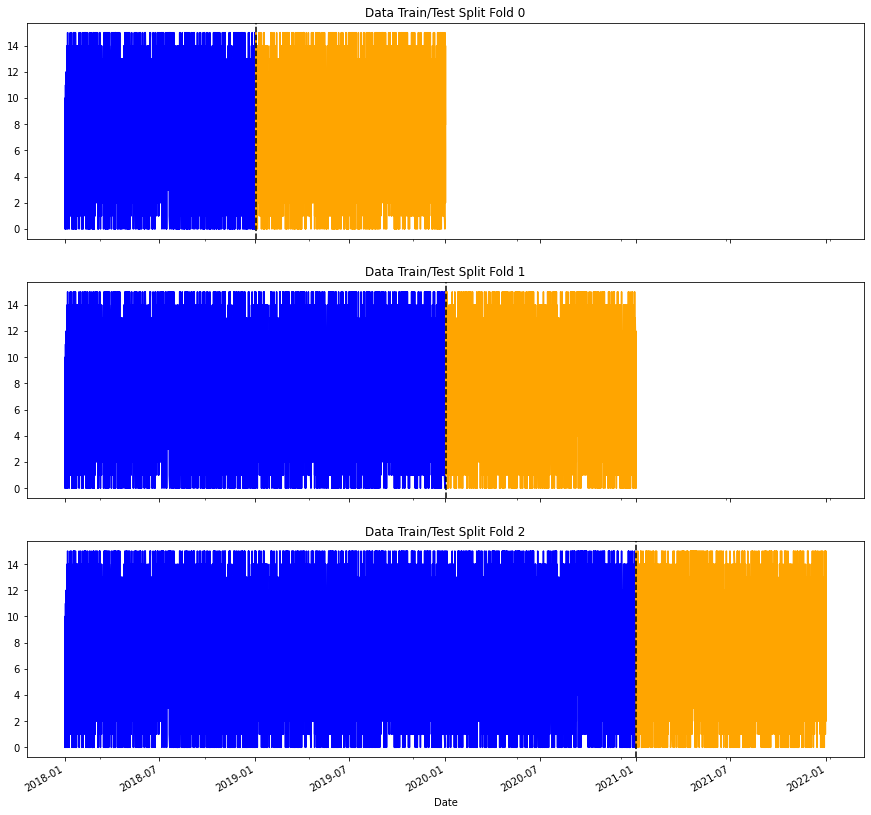

In [58]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=8*365*1, gap=8)
df = df.sort_index()

fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Available'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}',
                          color='blue')
    test['Available'].plot(ax=axs[fold],
                         label='Test Set',
                         color='orange')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## --------------------------------------------------------------------------------------------------------------------------

# Advanced Model Analysis and Refinement

## --------------------------------------------------------------------------------------------------------------------------

In [26]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [27]:
def add_lags(df):
    target_map = df['Occupied'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    return df

In [28]:
df = create_features(df)
df = add_lags(df)

In [29]:
# Split the data into training and validation sets
tss = TimeSeriesSplit(n_splits=3, test_size=8*365*1, gap=8)
df = df.sort_index()

In [30]:
# Train and validate the XGBoost model
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2']
    TARGET = 'Occupied'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[20:18:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:41.90459	validation_1-rmse:41.87109
[100]	validation_0-rmse:15.93265	validation_1-rmse:16.07793
[200]	validation_0-rmse:7.23495	validation_1-rmse:7.80461
[300]	validation_0-rmse:5.01346	validation_1-rmse:5.41943
[400]	validation_0-rmse:4.61952	validation_1-rmse:4.93830
[500]	validation_0-rmse:4.55426	validation_1-rmse:4.87108
[532]	validation_0-rmse:4.54625	validation_1-rmse:4.88063
[20:18:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:41.89215	validation_1-rmse:41.84328
[100]	validation_0-rmse:15.91990	validation_1-rmse:15.86738
[200]	valida

In [31]:
# Evaluate the model
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 4.7260
Fold scores:[4.868054043888383, 4.678480476585141, 4.6315926269653955]


In [32]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2']
TARGET = 'Occupied'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=10000,
    objective='reg:linear',
    max_depth=3,
    learning_rate=0.01
)
reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[20:18:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:41.87965
[100]	validation_0-rmse:15.91335
[200]	validation_0-rmse:7.21829
[300]	validation_0-rmse:5.00593
[400]	validation_0-rmse:4.62312
[500]	validation_0-rmse:4.56406
[600]	validation_0-rmse:4.55123
[700]	validation_0-rmse:4.54487
[800]	validation_0-rmse:4.53966
[900]	validation_0-rmse:4.53434
[1000]	validation_0-rmse:4.52918
[1100]	validation_0-rmse:4.52321
[1200]	validation_0-rmse:4.51791
[1300]	validation_0-rmse:4.51306
[1400]	validation_0-rmse:4.50863
[1500]	validation_0-rmse:4.50443
[1600]	validation_0-rmse:4.50012
[1700]	validation_0-rmse:4.49615
[1800]	validation_0-rmse:4.49231
[1900]	validation_0-rmse:4.48861
[2000]	validation_0-rmse:4.48440
[2100]	validation_0-rmse:4.47999
[2200]	validation_0-rmse:4.47566
[2300]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [33]:
print(df.index.max())

2021-12-31 09:00:00


In [34]:
future = pd.date_range(start='2022-01-01 00:00:00', end='2023-12-31 23:59:59', freq='15min')

# Filter the dates to include only those between 7am and 9am
time_range = future[(future.time >= pd.Timestamp('07:15:00').time()) & (future.time <= pd.Timestamp('09:00:00').time())]

In [35]:
print(time_range)

DatetimeIndex(['2022-01-01 07:15:00', '2022-01-01 07:30:00',
               '2022-01-01 07:45:00', '2022-01-01 08:00:00',
               '2022-01-01 08:15:00', '2022-01-01 08:30:00',
               '2022-01-01 08:45:00', '2022-01-01 09:00:00',
               '2022-01-02 07:15:00', '2022-01-02 07:30:00',
               ...
               '2023-12-30 08:45:00', '2023-12-30 09:00:00',
               '2023-12-31 07:15:00', '2023-12-31 07:30:00',
               '2023-12-31 07:45:00', '2023-12-31 08:00:00',
               '2023-12-31 08:15:00', '2023-12-31 08:30:00',
               '2023-12-31 08:45:00', '2023-12-31 09:00:00'],
              dtype='datetime64[ns]', length=5840, freq=None)


In [36]:
# Create future dataframe
future_df = pd.DataFrame(index=time_range)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [37]:
df_and_future

,Day,Parking,Total,Occupied,Available,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,isFuture
2018-01-01 07:15:00,Monday,New York,50.0,43.0,7.0,7,0,1,1,2018,1,1,1,NaN,NaN,NaN,False
2018-01-01 07:30:00,Monday,New York,50.0,47.0,3.0,7,0,1,1,2018,1,1,1,NaN,NaN,NaN,False
2018-01-01 07:45:00,Monday,New York,50.0,49.0,1.0,7,0,1,1,2018,1,1,1,NaN,NaN,NaN,False
2018-01-01 08:00:00,Monday,New York,50.0,50.0,0.0,8,0,1,1,2018,1,1,1,NaN,NaN,NaN,False
2018-01-01 08:15:00,Monday,New York,50.0,46.0,4.0,8,0,1,1,2018,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 08:00:00,NaN,NaN,NaN,NaN,NaN,8,6,4,12,2023,365,31,52,NaN,NaN,NaN,True
2023-12-31 08:15:00,NaN,NaN,NaN,NaN,NaN,8,6,4,12,2023,365,31,52,NaN,NaN,NaN,True
2023-12-31 08:30:00,NaN,NaN,NaN,NaN,NaN,8,6,4,12,2023,365,31,52,NaN,NaN,NaN,True
2023-12-31 08:45:00,NaN,NaN,NaN,NaN,NaN,8,6,4,12,2023,365,31,52,NaN,NaN,NaN,True


In [38]:
future_w_features = df_and_future.query('isFuture').copy()

future_w_features

,Day,Parking,Total,Occupied,Available,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,isFuture
2022-01-01 07:15:00,NaN,NaN,NaN,NaN,NaN,7,5,1,1,2022,1,1,52,NaN,42.0,47.0,True
2022-01-01 07:30:00,NaN,NaN,NaN,NaN,NaN,7,5,1,1,2022,1,1,52,NaN,50.0,35.0,True
2022-01-01 07:45:00,NaN,NaN,NaN,NaN,NaN,7,5,1,1,2022,1,1,52,NaN,43.0,35.0,True
2022-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,8,5,1,1,2022,1,1,52,NaN,37.0,35.0,True
2022-01-01 08:15:00,NaN,NaN,NaN,NaN,NaN,8,5,1,1,2022,1,1,52,NaN,40.0,38.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 08:00:00,NaN,NaN,NaN,NaN,NaN,8,6,4,12,2023,365,31,52,NaN,NaN,NaN,True
2023-12-31 08:15:00,NaN,NaN,NaN,NaN,NaN,8,6,4,12,2023,365,31,52,NaN,NaN,NaN,True
2023-12-31 08:30:00,NaN,NaN,NaN,NaN,NaN,8,6,4,12,2023,365,31,52,NaN,NaN,NaN,True
2023-12-31 08:45:00,NaN,NaN,NaN,NaN,NaN,8,6,4,12,2023,365,31,52,NaN,NaN,NaN,True


## --------------------------------------------------------------------------------------------------------------------------

## Predicting and Visualizing Future Occupancy using XGBoost Regressor Model

## --------------------------------------------------------------------------------------------------------------------------

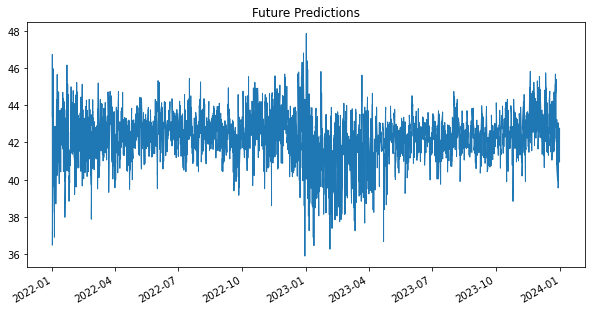

In [39]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                              
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [43]:
path = 'Future_Prediction_New7.csv'
future_w_features.to_csv(path)